In [3]:
from imutils.contours import sort_contours
import numpy as np
import pytesseract
import argparse
import imutils
import sys
import cv2
import json
import jsonpickle
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from IPython.display import display
import math
from skimage.filters import threshold_local
import pathlib
import os

In [4]:
#image_path = "../data/passport_data/test_british.png"
#image_path = "../data/passport_data/passport_1.png"
image_path = "../data/passport_data/test_aus.jpg"
filename = pathlib.Path(image_path).stem
save_path = os.path.join("../data/passport_data/",f"{filename}_pers.jpg")

In [5]:
filename

'test_aus'

In [6]:
def show_image(image,cmap=""):
    if not cmap:
        plt.imshow(image)
    else:
        plt.imshow(image,cmap=cmap)

    # display that image
    plt.show()

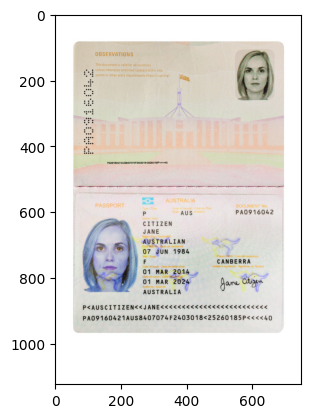

In [7]:
show_image(image = cv2.imread(image_path))

In [8]:
def perspective_image(image_path,save_path):
    def order_points(pts):
        # initialzie a list of coordinates that will be ordered
        # such that the first entry in the list is the top-left,
        # the second entry is the top-right, the third is the
        # bottom-right, and the fourth is the bottom-left
        rect = np.zeros((4, 2), dtype = "float32")

        # the top-left point will have the smallest sum, whereas
        # the bottom-right point will have the largest sum
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]

        # now, compute the difference between the points, the
        # top-right poi
        # nt will have the smallest difference,
        # whereas the bottom-left will have the largest difference
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]

        # return the ordered coordinates
        return rect
    
    def four_point_transform(image, pts):
        # obtain a consistent order of the points and unpack them
        # individually
        rect = order_points(pts)
        (tl, tr, br, bl) = rect

        # compute the width of the new image, which will be the
        # maximum distance between bottom-right and bottom-left
        # x-coordiates or the top-right and top-left x-coordinates
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))

        # compute the height of the new image, which will be the
        # maximum distance between the top-right and bottom-right
        # y-coordinates or the top-left and bottom-left y-coordinates
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))

        # now that we have the dimensions of the new image, construct
        # the set of destination points to obtain a "birds eye view",
        # (i.e. top-down view) of the image, again specifying points
        # in the top-left, top-right, bottom-right, and bottom-left
        # order
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")

        # compute the perspective transform matrix and then apply it
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

        # return the warped image
        return warped
    # read the input image
    image = cv2.imread(image_path)

    # clone the original image
    original_image = image.copy()

    # resize using ratio (old height to the new height)
    ratio = image.shape[0] / 500.0
    image = imutils.resize(image, height=500)
    #  change the color space to YUV
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # grap only the Y component
    image_y = np.zeros(image_yuv.shape[0:2], np.uint8)
    image_y[:, :] = image_yuv[:, :, 0]
    # blur the image to reduce high frequency noises
    image_blurred = cv2.GaussianBlur(image_y, (3, 3), 0)
    # find edges in the image
    edges = cv2.Canny(image_blurred, 50, 200, apertureSize=3)
    # find contours
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # draw all contours on the original image
    cv2.drawContours(image, contours, -1, (0, 255, 0), 1)
    # !! Attention !! Do not draw contours on the image at this point
    # I have drawn all the contours just to show below image
    # to collect all the detected polygons
    polygons = []

    # loop over the contours
    for cnt in contours:
        # find the convex hull
        hull = cv2.convexHull(cnt)

        # compute the approx polygon and put it into polygons
        polygons.append(cv2.approxPolyDP(hull, 0.01 * cv2.arcLength(hull, True), False))
    # sort polygons in desc order of contour area
    sortedPoly = sorted(polygons, key=cv2.contourArea, reverse=True)

    # draw points of the intersection of only the largest polyogon with red color
    cv2.drawContours(image, sortedPoly[0], -1, (0, 0, 255), 5)
    
    # get the contours of the largest polygon in the image
    simplified_cnt = sortedPoly[0]
    print(simplified_cnt)
    # check if the polygon has four point
    if len(simplified_cnt) == 4:
        # trasform the prospective of original image
        cropped_image = four_point_transform(original_image, simplified_cnt.reshape(4, 2) * ratio)
    else:
        cropped_image=image
    
    # Binarize the cropped image
    gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray_image, 11, offset=10, method="gaussian")
    binarized_image = (gray_image > T).astype("uint8") * 255
    # Show images
    show_image(original_image)
    show_image(binarized_image)
    show_image(cropped_image)
    print("save_path= ",save_path)
    cv2.imwrite(save_path,cropped_image)
    return cropped_image

[[[308 422]]

 [[ 24 425]]

 [[ 26  39]]

 [[308  42]]]


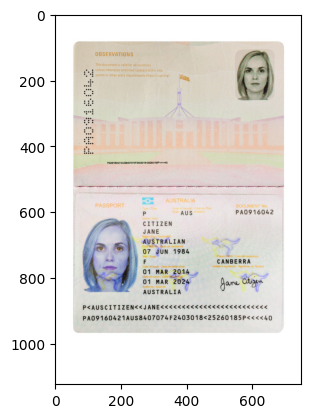

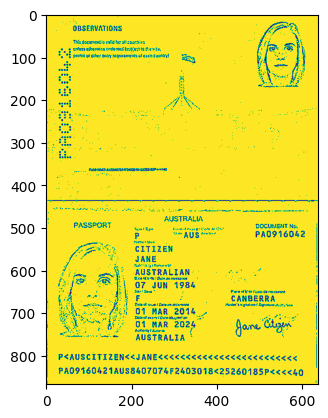

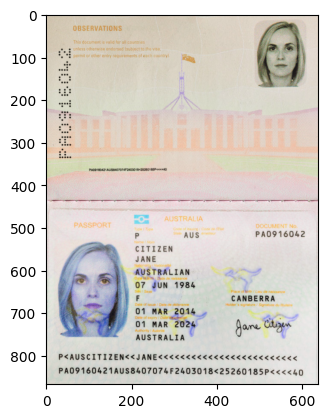

save_path=  ../data/passport_data/test_aus_pers.jpg


In [9]:
perspective_image = perspective_image(image_path,save_path)

In [10]:
perspective_image.shape

(867, 638, 3)

In [11]:

def split_passport(image_path):
    def discard(image):
        image = np.uint8(image)
        _, im_label, stts, _ = cv2.connectedComponentsWithStats(image, connectivity=4)

        msk1 = np.isin(im_label, np.where(stts[:, cv2.CC_STAT_WIDTH] > 500)[0])
        msk2 = np.isin(im_label, np.where(stts[:, cv2.CC_STAT_HEIGHT] > 500)[0])

        image[(msk1 | msk2)] = 0
        return image


    img = cv2.imread(image_path, 0)
    img = cv2.resize(img, None, fx=0.35, fy=0.35, interpolation=cv2.INTER_LINEAR)
    height, width = img.shape[:2]

    # Binarization
    thresh = 255 - img
    ret, thresh = cv2.threshold(thresh, 5, 255, cv2.THRESH_BINARY)

    # Discarding long connected components
    without_lines = discard(thresh.copy())
    just_lines = cv2.bitwise_xor(thresh, without_lines)
    horizontal = just_lines.copy()

    # separating horizontal line
    h_kernel_large = np.array([[0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0],
                               [1, 1, 1, 1, 1],
                               [0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0]], np.uint8)
    horizontal = cv2.morphologyEx(horizontal, cv2.MORPH_OPEN, h_kernel_large, iterations=2)
    cv2.imwrite("horizontal_line.jpg",horizontal)

In [12]:
split_passport(save_path)

In [249]:
#%cd ../training/src_updated/

In [250]:
#%cd ../../card-rectification/

In [251]:
#%pwd

In [252]:
## call perspective
#%run -i rectify.py  passport_rotated.jpg result/passport_rotated_pers.jpg

In [253]:
def extract_mrz(image_path,crop=False):
    image = cv2.imread(image_path)
    show_image(image)
    if crop:
        print("In crop")
        # Get the dimensions of the image
        height, width = image.shape[:2]
        # Crop the image in half
        half_height = height // 2
        image = image[half_height:,:]
    image = cv2.resize(image, (1000, 450))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (H, W) = gray.shape
    print()
    # initialize a rectangular and square structuring kernel
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 7))
    sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    # smooth the image using a 3x3 Gaussian blur and then apply a
    # blackhat morpholigical operator to find dark regions on a light
    # background
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
    #show_image("Blackhat", blackhat)
    #cv2.imshow("Blackhat", blackhat)
    # compute the Scharr gradient of the blackhat image and scale the
    # result into the range [0, 255]
    grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad = np.absolute(grad)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (grad - minVal) / (maxVal - minVal)
    grad = (grad * 255).astype("uint8")
    show_image(grad,"gray")
    #cv2.imshow("Gradient", grad)
    # apply a closing operation using the rectangular kernel to close
    # gaps in between letters -- then apply Otsu's thresholding method
    grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
    thresh = cv2.threshold(grad, 0, 255,
                           cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
    thresh = cv2.erode(thresh, None, iterations=2)
    show_image(thresh,"gray")
    ## DETERMINE CONTOURS AND FILTER THEM
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    #make a copy of the resized image since we are going to draw contours on the resized image
    resizedImageCopy=np.copy(image)

    # draw all contours with setting the parameter to -1
    # but if you use this function, you should comment the for loop below
    #cv2.drawContours(resizedImageCopy,contours,-1,(0,0,255),2)
    #filter contours 
    for i, c in enumerate(contours):
        areaContour=cv2.contourArea(c)
        if areaContour<2000 or 100000<areaContour:
            continue
        cv2.drawContours(resizedImageCopy,contours,i,(255,10,255),4)

    # # display the original image with contours
    # cv2.imshow('Image', resizedImageCopy)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # cv2.imwrite("resizedPartsContours.png", resizedImageCopy, [cv2.IMWRITE_PNG_COMPRESSION, 0]) 
    show_image(resizedImageCopy,"gray")
    mrzBox = ""
    # loop over the contours
    for i,c in enumerate(contours):
        # compute the bounding box of the contour and then derive the
        # how much of the image the bounding box occupies in terms of
        # both width and height
        (x, y, w, h) = cv2.boundingRect(c)
        percentWidth = w / float(W)
        percentHeight = h / float(H)
        # if the bounding box occupies > 80% width and > 4% height of the
        # image, then assume we have found the MRZ
        if percentWidth > 0.7 and percentHeight > 0.04 and y >=H/2:
            print('y = ',y)
#             print("% width",percentWidth)
#             print("% height",percentHeight)
            mrzBox = (x, y, w, h)
    print("before expanding")
    print(mrzBox)
    # if the MRZ was not found, exit the script
    if mrzBox is None:
        print("[INFO] MRZ could not be found")
        sys.exit(0)
    # pad the bounding box since we applied erosions and now need to
    # re-grow it
    (x, y, w, h) = mrzBox
    pX = int((x + w) * 0.02)
    pY = int((y + h) * 0.02)
    print("px =",pX)
    print("py= ",pY)
    (x, y) = (x - pX, y - (pY * 3))
    (w, h) = (w + (pX * 3), h + (pY * 6))
    print("after expanding")
    print(x,y,w,h)
    # extract the padded MRZ from the image
    mrz = gray[y:y + h, x:x + w]
    mrz_color = cv2.cvtColor(mrz,cv2.COLOR_GRAY2RGB)
    show_image(mrz,"gray")
    return mrz_color

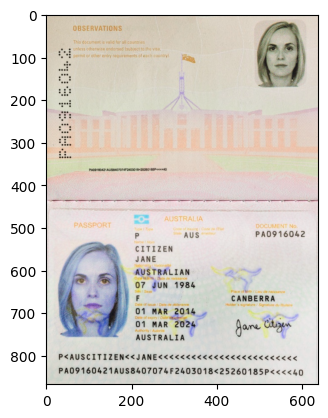

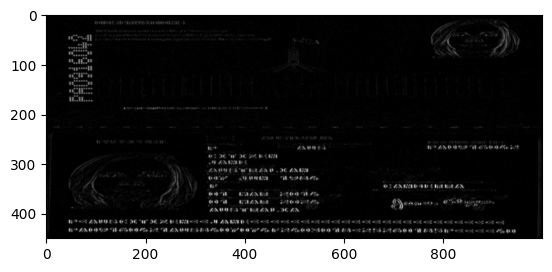

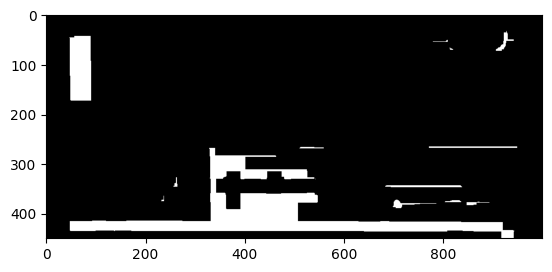

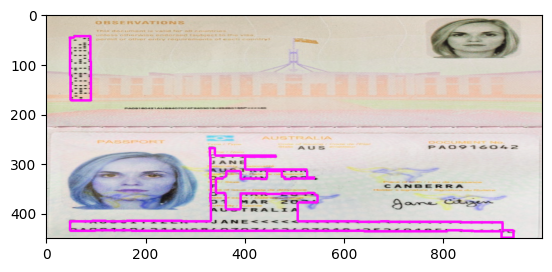

y =  269
before expanding
(48, 269, 896, 181)
px = 18
py=  9
after expanding
30 242 950 235


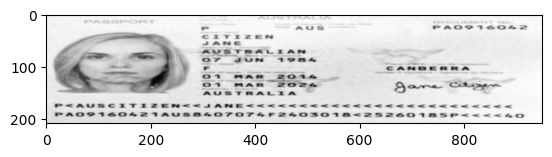

In [254]:
mrz = extract_mrz(save_path)

In [255]:
#mrz box =  (23, 372, 943, 47)
#mrz box =  (92, 346, 787, 37)
# before expanding
# (23, 372, 943, 47)
# after expanding
# -15 343 1019 105

# y =  346
# before expanding
# (92, 346, 787, 37)
# after expanding
# 57 320 857 89

In [256]:
def retreive_data(mrz_row_list):
#     print(mrz_row_list)
    detail_dict = {}
    line1_words = mrz_row_list[0].split("<")
    line2_words = mrz_row_list[1].split("<")
    detail_dict["Name"] = " ".join(line1_words[2:]) + " "+ line1_words[1][3:]
    detail_dict["country_code"] = line1_words[1][:3]
    detail_dict["pp_no"] = line2_words[0][:9]
    detail_dict["nationality"] = line2_words[0][10:13]
    #detail_dict["data_of_birth"] = datetime.strptime(line2_words[0][13:19], "%y%m%d").strftime("%d-%m-%y")
    detail_dict["data_of_birth"] = line2_words[0][13:19]
    detail_dict["gender"] = line2_words[0][20:21]
    #detail_dict["expiry_date"] = datetime.strptime(line2_words[0][21:27], "%d%m%y").strftime("%d-%m-%y")
    detail_dict["expiry_date"] = line2_words[0][21:27]
    return detail_dict

In [257]:
def extract_text(mrz):
    mrzText = pytesseract.image_to_string(mrz,lang='eng')
    print("mrz text = ",mrzText)
    mrzlist=mrzText.split('\n')[:-1]
    print("mrz text = ",mrzText)
#     mrzlist = filter(None, mrzlist)
#     mrzlist = filter(bool, mrzlist)
#     mrzlist = filter(len, mrzlist)
#     mrzlist = filter(lambda item: item, mrzlist)
#     mrzlist = list(filter(None, mrzlist))
    mrzlist=' '.join(mrzlist).split()
    #mrzlist=[i for i in mrzlist if i]
    print("mrz list = ",mrzlist)
    data = retreive_data(mrzlist)
    df = pd.DataFrame(data.items(),columns = ["Passport Key","Value"])
    return df

In [258]:
df = extract_text(mrz)

mrz text =  PAos1sSG4e

 

ae0=00 OOO

 

P<AuUSCEY © 2eON<< 5 ANE «<<< <<<<<«<<<<<<<<<<<<<<<<<<
PACS 1604274 AUS 8407074 F24053018<25260185r<<<<40

mrz text =  PAos1sSG4e

 

ae0=00 OOO

 

P<AuUSCEY © 2eON<< 5 ANE «<<< <<<<<«<<<<<<<<<<<<<<<<<<
PACS 1604274 AUS 8407074 F24053018<25260185r<<<<40

mrz list =  ['PAos1sSG4e', 'ae0=00', 'OOO', 'P<AuUSCEY', '©', '2eON<<', '5', 'ANE', '«<<<', '<<<<<«<<<<<<<<<<<<<<<<<<', 'PACS', '1604274', 'AUS', '8407074', 'F24053018<25260185r<<<<40']


IndexError: list index out of range

In [ ]:
display(df)

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
display(df)

In [ ]:
#del json_dict['index']

In [ ]:
df.to_json(os.path.join(f'../data/extraction_results/{filename}.json'))